In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!pip install wordcloud
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

!pip install scikeras
from scikeras.wrappers import KerasClassifier

from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Conv2D, Reshape, GlobalMaxPooling2D
from tensorflow.python.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


2024-02-12 19:38:06.089448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 19:38:06.089599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 19:38:06.228119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [99]:
tweets_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
tweets_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [100]:
tweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [101]:
tweets_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [102]:
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [103]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


In [104]:
tweets_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [105]:
tweets_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [106]:
tweets_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [107]:
tweets_train = tweets_train.dropna()
tweets_train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [108]:
tweets_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [109]:
tweets_test = tweets_test.dropna()
tweets_test.isnull().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

In [110]:
sample.isnull().sum()

id        0
target    0
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


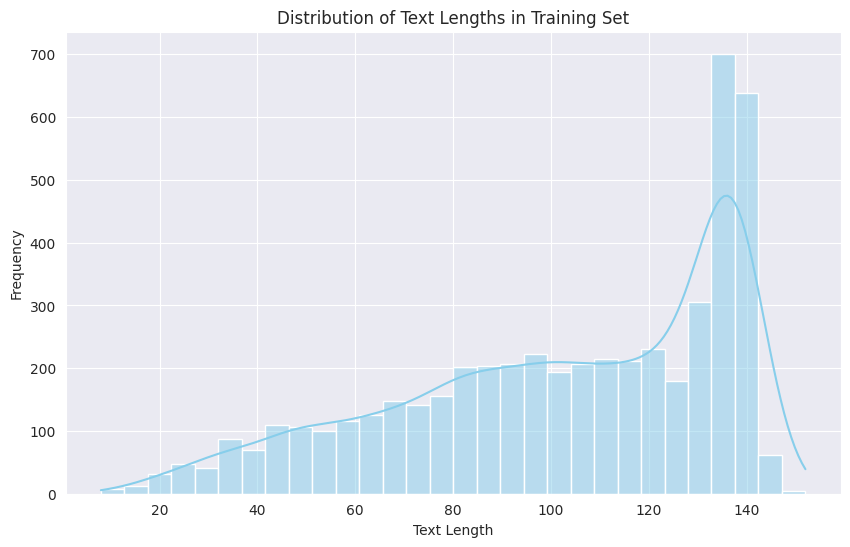

In [111]:
plt.figure(figsize=(10, 6))
sns.histplot(tweets_train['text'].apply(len), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Text Lengths in Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

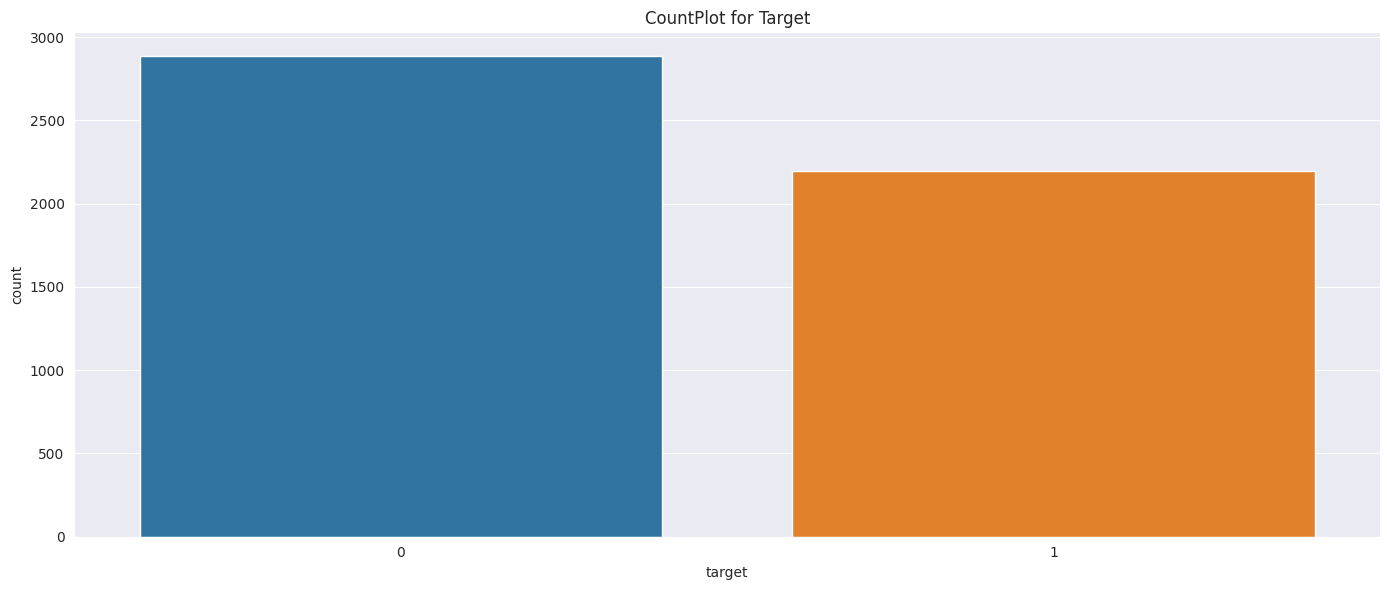

In [112]:
plt.figure(figsize=(14,6))
sns.set_style('darkgrid')
sns.countplot(data=tweets_train, x='target')
plt.title('CountPlot for Target')
plt.tight_layout()
plt.show()

In [113]:
def clean_text(text):
    text = ' '.join(text)
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]"," ",text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    porter_stemmer = PorterStemmer()
    stemmed_text = [porter_stemmer.stem(word) for word in filtered_tokens]
    
    return stemmed_text

In [114]:
tweets_train['stemmed_text'] = tweets_train['text'].apply(clean_text)
tweets_train

,id,keyword,location,text,target,stemmed_text
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,"[b, b, c, w, h, l, e, l, e, r, k, e, b, l, z, ..."
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,"[w, e, l, w, r, b, r, n, g, h, e, h, e, v, e, ..."
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,"[f, r, c, n, b, z, e, b, r, e, k, n, g, n, e, ..."
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,"[c, r, n, g, u, f, r, r, e, e, e, b, l, z, e]"
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,"[n, p, l, u, e, l, k, h, e, k, l, n, g, h, w, ..."
...,...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,"[n, h, e, b, r, g, h, e, w, r, e, c, k, e, h, ..."
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0,"[w, h, e, g, n, e, u, c, n, r, e, l, x, h, u, ..."
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,"[h, r, e, e, f, f, f, r, w, r, k, n, h, e, v, ..."
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,"[f, x, f, r, e, x, r, n, g, c, r, e, r, g, e, ..."


In [141]:
tweets_test['stemmed_text'] = tweets_test['text'].apply(clean_text)
tweets_test

,id,keyword,location,text,stemmed_text
15,46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...,"[b, r, n, g, h, w, h, l, e, l, e, r, k, e, b, ..."
16,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...,"[u, n, k, x, e, h, r, r, w, l, l, u, w, e, r, ..."
17,51,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,"[p, r, e, v, u, l, n, n, v, k, e, k, n, w, r, ..."
18,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,"[c, h, e, c, k, h, e, e, u, h, p, c, r, n, e, ..."
19,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...,"[p, p, l, n, g, p, e, r, n, l, e, e, c, h, e, ..."
...,...,...,...,...,...
3246,10804,wrecked,Love Reiss,@yakubOObs think he deactivated because his no...,"[k, u, b, b, h, n, k, h, e, e, c, v, e, b, e, ..."
3247,10806,wrecked,Seattle Washington,RT CNBC '3 words from Disney CEO Bob Iger wrec...,"[r, c, n, b, c, w, r, f, r, n, e, c, e, b, b, ..."
3248,10807,wrecked,Acey mountain islanddåÇTorontoåÈ,Smackdown tyme this should put me in a good mo...,"[c, k, w, n, e, h, h, u, l, p, u, e, n, g, g, ..."
3249,10816,wrecked,los angeles,@thrillhho jsyk I haven't stopped thinking abt...,"[h, r, l, l, h, h, j, k, h, v, e, n, p, p, e, ..."


In [115]:
disaster = ''.join(tweets_train[tweets_train['target'] == 1]['text'])
non_disaster = ''.join(tweets_train[tweets_train['target']==0]['text'])

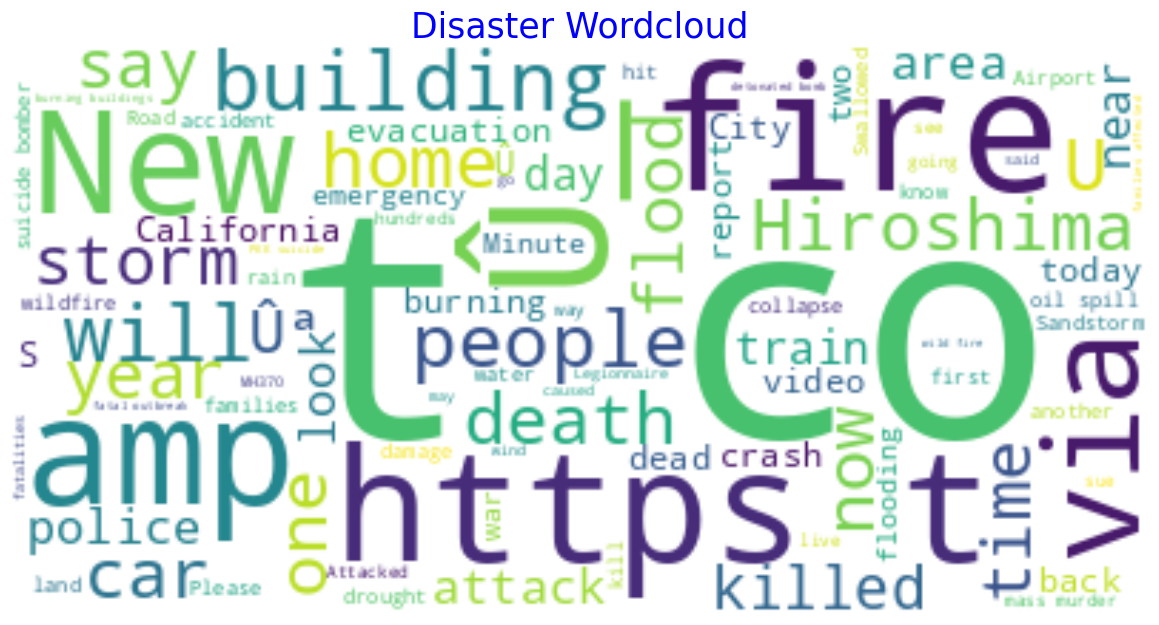

In [116]:
plt.figure(figsize=(14,6))
wordcloud = WordCloud(background_color = 'white').generate(disaster)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.title('Disaster Wordcloud',fontsize= 25,color='Blue')
plt.show()

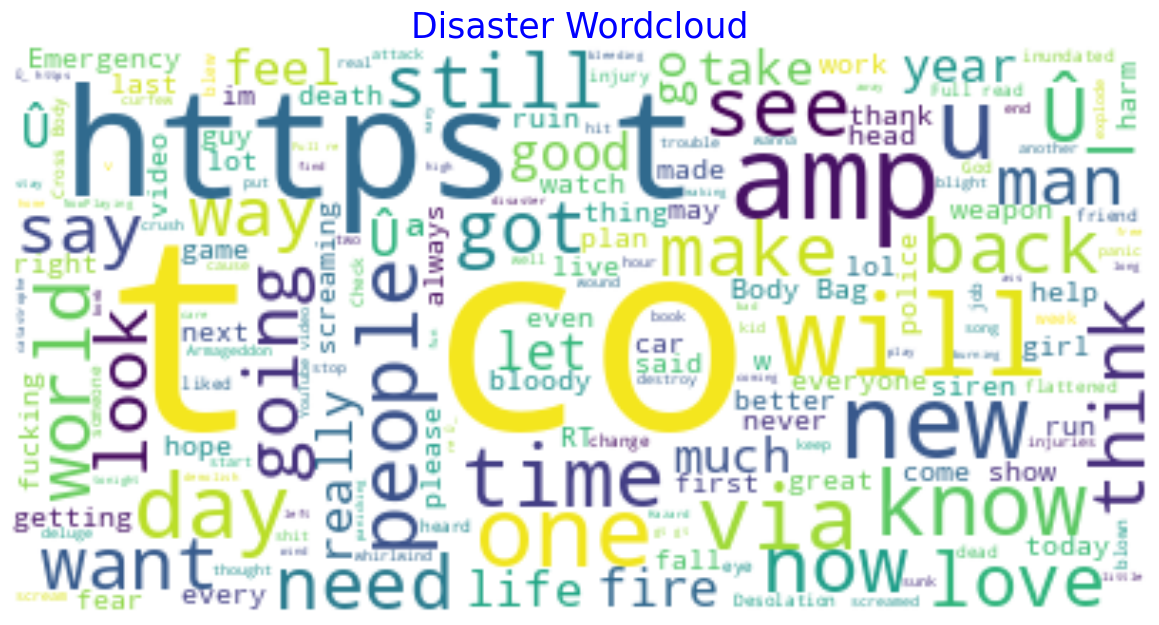

In [117]:
plt.figure(figsize=(14,6))
wordcloud = WordCloud(background_color = 'white').generate(non_disaster)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.title('Disaster Wordcloud',fontsize= 25,color='Blue')
plt.show()

In [144]:
train_data, test_data, train_labels, test_labels = train_test_split(tweets_train['text'], tweets_train['target'], test_size=0.2, random_state=42)
# test_data
tweets_test['text']

15      Birmingham Wholesale Market is ablaze BBC News...
16      @sunkxssedharry will you wear shorts for race ...
17      #PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...
18      Check these out: http://t.co/rOI2NSmEJJ http:/...
19      PSA: IÛªm splitting my personalities.\n\n?? t...
                              ...                        
3246    @yakubOObs think he deactivated because his no...
3247    RT CNBC '3 words from Disney CEO Bob Iger wrec...
3248    Smackdown tyme this should put me in a good mo...
3249    @thrillhho jsyk I haven't stopped thinking abt...
3250    @stighefootball Begovic has been garbage. He g...
Name: text, Length: 2158, dtype: object

### Model 1: Naive Bayes with TF-IDF Vectorizer

In [48]:
model = make_pipeline(
    TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords.words('english')),
    MultinomialNB()
)

In [49]:
model.fit(train_data, train_labels)

predictions = model.predict(test_data)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [50]:
accuracy = accuracy_score(test_labels, predictions)
classification_rep = classification_report(test_labels, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.793827971109652
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84       874
           1       0.84      0.63      0.72       649

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



### Model 2: LSTM(Long Short-Term Memory) Model

In [134]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)
tweets_test_sequences = tokenizer.texts_to_sequences(tweets_test['text'])

max_length = 100
train_data_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_data_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')
tweets_test_padded = pad_sequences(tweets_test_sequences,maxlen=max_length, padding='post')

In [52]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)


def create_model_1(learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [53]:
model_1 = KerasClassifier(build_fn=create_model_1, learning_rate = 0.001, epochs=5, batch_size=64, verbose=0)
param_grid_1 = {'learning_rate':[0.001, 0.01,0.1],'epochs': [5, 10], 'batch_size': [64, 128]}

In [54]:
grid_search_1 = GridSearchCV(model_1, param_grid_1, cv=2)
grid_search_1.fit(train_data_padded, train_labels_encoded)

/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras

GridSearchCV(cv=2,
             estimator=KerasClassifier(batch_size=64, build_fn=<function create_model_1 at 0x7c0e56114160>, epochs=5, learning_rate=0.001, verbose=0),
             param_grid={'batch_size': [64, 128], 'epochs': [5, 10],
                         'learning_rate': [0.001, 0.01, 0.1]})

In [57]:
best_params_1 = grid_search_1.best_params_
best_params_1

{'batch_size': 64, 'epochs': 5, 'learning_rate': 0.1}

In [58]:
model_1_best = create_model_1()
model_1_best.fit(train_data_padded, train_labels_encoded, epochs=best_params_1['epochs'], batch_size=best_params_1['batch_size'])

Epoch 1/5
96/96 [==============================] - 10s 78ms/step - loss: 0.6848 - accuracy: 0.5672
Epoch 2/5
96/96 [==============================] - 7s 74ms/step - loss: 0.6843 - accuracy: 0.5695
Epoch 3/5
96/96 [==============================] - 7s 73ms/step - loss: 0.6841 - accuracy: 0.5695
Epoch 4/5
96/96 [==============================] - 7s 73ms/step - loss: 0.6841 - accuracy: 0.5695
Epoch 5/5
96/96 [==============================] - 7s 73ms/step - loss: 0.6844 - accuracy: 0.5695


In [59]:
predictions_1 = model_1_best.predict(test_data_padded)
predictions_1 = np.round(predictions_1.flatten()).astype(int)

48/48 [==============================] - 1s 15ms/step


In [74]:
classification_rep_1 = classification_report(test_labels_encoded, predictions_1)
print("Classification Report:\n", classification_rep_1)

Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.42      1523



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 3: Conv1D Neural Network Model 

In [61]:
def create_model_3(learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [62]:
model_3 = KerasClassifier(build_fn=create_model_3, learning_rate = 0.001,epochs=5, batch_size=64, verbose=0)

In [63]:
param_grid_3 = {'learning_rate':[0.001, 0.01,0.1],'epochs': [5, 10], 'batch_size': [64, 128]}

In [64]:
grid_search_3 = GridSearchCV(model_3, param_grid_3, cv=2)
grid_search_3.fit(train_data_padded, train_labels_encoded)

/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras

GridSearchCV(cv=2,
             estimator=KerasClassifier(batch_size=64, build_fn=<function create_model_3 at 0x7c0e554eb370>, epochs=5, learning_rate=0.001, verbose=0),
             param_grid={'batch_size': [64, 128], 'epochs': [5, 10],
                         'learning_rate': [0.001, 0.01, 0.1]})

In [65]:
best_params_3 = grid_search_3.best_params_
best_params_3

{'batch_size': 128, 'epochs': 5, 'learning_rate': 0.001}

In [67]:
model_3_best = create_model_3()
model_3_best.fit(train_data_padded, train_labels_encoded, epochs=best_params_3['epochs'], batch_size=best_params_3['batch_size'])

Epoch 1/5
48/48 [==============================] - 3s 38ms/step - loss: 0.6464 - accuracy: 0.6259
Epoch 2/5
48/48 [==============================] - 2s 34ms/step - loss: 0.4779 - accuracy: 0.8041
Epoch 3/5
48/48 [==============================] - 2s 32ms/step - loss: 0.3197 - accuracy: 0.8731
Epoch 4/5
48/48 [==============================] - 2s 33ms/step - loss: 0.2186 - accuracy: 0.9207
Epoch 5/5
48/48 [==============================] - 2s 33ms/step - loss: 0.1485 - accuracy: 0.9511


In [68]:
predictions_3 = model_3_best.predict(test_data_padded)
predictions_3 = np.round(predictions_3.flatten()).astype(int)

48/48 [==============================] - 0s 4ms/step


In [75]:
classification_rep_3 = classification_report(test_labels_encoded, predictions_3)
print("Classification Report:\n", classification_rep_3)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82       874
           1       0.77      0.73      0.75       649

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523



In [168]:
submission = pd.DataFrame({'id':test_labels_encoded,'target':predictions_3})
submission

,id,target
0,1,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
1518,0,1
1519,1,1
1520,1,1
1521,1,1


In [169]:
submission.to_csv('submission.csv',index = True)